Author:
        
        PARK, JunHo, junho@ccnets.org

        
        KIM, JeongYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.

# Introduction to CCNet: A New Paradigm in Causal Learning

## Overview of CCNet
CCNet (Cooperative Causal Network) introduces a framework for understanding causal dynamics in observed data, specifically decoupling the direct causes of an observation (X) from the target outcome (Y). This model employs neural networks to identify explanatory factors in observed data that are conditionally independent of the target variable given the observations.

## A Method for Causal Learning with Neural Networks
CCNet elucidates the causal relationship between observed data (X) and target outcomes (Y) using three interconnected neural network models: the Explainer, the Reasoner, and the Producer. This tutorial aims to demonstrate the conditional independence of explanatory factors (E) from the target outcome (Y) given the observation (X).

## Experiment Description

### Objective
Empirically validate the conditional independence of explanatory factors (E) from the target outcome (Y) given the observations (X) using CCNet in the context of credit card fraud detection.

### Dataset
The experiment uses a credit card fraud detection dataset, comprising features related to transaction details and the target variable indicating fraud. Specifically:
- `df_y_class`: The binary target indicating fraud status, used for binary classification.
- `df_y_amount`: The continuous target indicating transaction amount, used for regression.

This dataset serves as the basis for configuring the causal model dataset for training CCNet.

### Methodology

#### Dataset Preparation
- **CausalModelDataset**: Configures the dataset to include specific features hypothesized to be causally related to the target outcomes. For fraud detection, this includes features relevant to transactions, with either `df_y_class` or `df_y_amount` as the target.
- **EncodingDataset**: Generates encodings (explanatory factors) from the dataset using the causal model for classifier training.

#### Training Process
- **Causal Model Training**: Iteratively train the causal model over several epochs to refine the understanding of causal relationships between transaction features and the outcomes.
- **Classifier Training and Evaluation**:
  - **Selected Feature Classifier**: Trained on encodings of the selected features. In the context of this experiment, this would involve either the binary classification or regression task for fraud detection using `df_y_class` or `df_y_amount`.
  - **Non-Selected Feature Classifier**: Trained on encodings of the non-selected features. Here, this would correspond to the regression task or binary classification using `df_y_amount` or `df_y_class`.
  - The training process also switches selected and non-selected features, training the causal model with different combinations (e.g., using fraud status and then transaction amounts) to evaluate the classifier's ability to predict other features.

#### Validation and Visualization
- **Performance Metrics**: Record accuracy and F1 score for the binary classification task, and mean squared error (MSE) and mean absolute error (MAE) for the regression task. These metrics are used to compare the effectiveness of the causal model.
- **Plotting Results**: Visualize performance trends over epochs to assess the impact of the causal model on classifier performance.

### Summary

The experiment aims to validate CCNet's proficiency in identifying and utilizing causal relationships in the credit card fraud detection dataset. By focusing on conditional independence and evaluating classifier performance across both binary classification (fraud detection using `df_y_class`) and regression (transaction amount prediction using `df_y_amount`), the experiment provides empirical evidence of CCNet's efficacy in causal generation. This highlights CCNet's ability to learn a generative graph that accurately captures the causal dynamics in fraudulent transactions.

### Key Insights

- **Target Versatility**: The experiment demonstrates the flexibility of CCNet in handling different types of target variables. Whether predicting fraud status (binary classification) or transaction amount (regression), the model adapts to learn the causal relationships effectively.
- **Conditional Independence**: The analysis emphasizes proving that explanatory factors (E) are conditionally independent of the target outcome (Y) given observations (X), ensuring robust causal inference.
- **Causal Generation**: The ability of CCNet to generate realistic transaction data based on learned causal relationships showcases its strength in modeling generative processes beyond simple prediction.


In [1]:
import sys
import pandas as pd 
path_append = "../"
sys.path.append(path_append)  # Go up one directory from where you are.

# https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_7_DeepLearning/FeedForwardNeuralNetworks.html

dataroot = path_append + "../data/credit_card_fraud_detection/creditcard.csv"
df = pd.read_csv(dataroot)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [2]:
print('No Frauds', round(df['Class'].value_counts()[0] / len(df) *100,2), '%of the dataset')
print('Frauds', round(df['Class'].value_counts()[1] / len(df) *100,2), '%of the dataset')

No Frauds 99.83 %of the dataset
Frauds 0.17 %of the dataset


In [3]:
import torch
from sklearn.preprocessing import StandardScaler, RobustScaler
from torch.utils.data import Dataset
from tools.preprocessing.data_frame import auto_preprocess_dataframe
from tools.preprocessing.scaler import scale_dataframe

df = df.sample(frac=1)

target_columns = ['Amount', 'Class']
df, description = auto_preprocess_dataframe(df, target_columns)
df, scale_amount = scale_dataframe(df, transform_columns = ['Amount'])
scale_class = None

df_x = df.drop(columns = target_columns)
df_y_class = df['Class']
task_type_class = 'binary_classification'

df_y_amount = df['Amount']
task_type_amount = 'regression'

X = torch.tensor(df_x.values, dtype=torch.float32)
y_class = torch.tensor(df_y_class.values, dtype=torch.float32).unsqueeze(-1)
y_amount = torch.tensor(df_y_amount.values, dtype=torch.float32).unsqueeze(-1)

num_features = description['num_features']

,Min,Max,Mean,Std,Null Count,Scaled,Encoded
Time,-2.215465,1.822074,-4.879872e-17,1.109630,0,Minmax,None
V1,-56.407510,2.454930,-1.347204e-18,1.958696,0,None,None
V2,-72.715728,22.057729,-2.220391e-17,1.651309,0,None,None
V3,-48.325589,9.382558,-2.185464e-17,1.516255,0,None,None
V4,-5.683171,16.875344,1.117680e-17,1.415869,0,None,None
V5,-113.743307,34.801666,-1.217473e-17,1.380247,0,None,None
V6,-26.160506,73.301626,1.107701e-17,1.332271,0,None,None
V7,-43.557242,120.589494,1.167577e-17,1.237094,0,None,None
V8,-73.216718,20.007208,1.347204e-18,1.194353,0,None,None
V9,-13.434066,15.594995,3.243268e-19,1.098632,0,None,None


In [4]:
# Defining the labeled and unlabeled dataset classes
class LabeledDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        vals = self.x[index] if isinstance(self.x, torch.Tensor) else torch.tensor(self.x[index], dtype=torch.float32)
        label = self.y[index] if isinstance(self.y, torch.Tensor) else torch.tensor(self.y[index], dtype=torch.float32)
        return vals, label

In [5]:

from nn.tabnet import TabNet 
from tools.setting.ml_params import ModelConfig

class PredictionModel(torch.nn.Module):
    def __init__(self, input_size, output_size, task_type, num_layers=3, hidden_size=256):
        super(PredictionModel, self).__init__()
        
        if task_type == 'binary_classification':
            final_act = torch.nn.Sigmoid()
        elif task_type == 'regression':
            final_act = torch.nn.Identity()
        
        self.final_act = final_act
        
        model_config = ModelConfig('tabnet')
        model_config.num_layers = num_layers
        model_config.d_model = hidden_size
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # Create a list to hold all layers
        layers = []
        
        # Input layer
        layers.append(torch.nn.Linear(input_size, hidden_size))
        layers.append(torch.nn.ReLU())
        
        ## Add TabNet layers
        layers.append(TabNet(model_config))
        layers.append(torch.nn.ReLU())

        # Output layer
        layers.append(torch.nn.Linear(hidden_size, output_size))
        
        # Register all layers
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return self.final_act(x)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display

# Helper function to normalize a metric to [0, 1]
def normalize_metric(metric):
    max_value = np.max(metric)
    if max_value == 0:
        return metric
    return metric / max_value

# Helper function to inverse scale a metric
def inverse_scale_metric(metric):
    return 1 / (1 + metric)

def display_plot(fig):
    plt.tight_layout()
    clear_output(wait=True)
    display(fig, display_id='fig')
    plt.pause(0.1)

def update_annot(ind, line, annot):
    pos = line.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = f"{pos[0]:.2f}, {pos[1]:.2f}"
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event, fig, ax, line, annot):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind, line, annot)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

def initialize_plot():
    plt.ioff()
    fig, ax = plt.subplots(figsize=(10, 6))
    return fig, ax

def plot_metric(ax, epochs, selected_results, none_selected_results, task_type_selected, task_type_non_selected):
    ax.cla()
    
    if task_type_selected == 'binary_classification':
        ax.plot(epochs, selected_results['f1_score'], label='Selected Attributes (F1 Score)')
    elif task_type_selected == 'regression':
        normalized_r2 = normalize_metric(selected_results['r2'])
        ax.plot(epochs, inverse_scale_metric(normalized_r2), label='Selected Attributes (Inverse R²)')
    
    if task_type_non_selected == 'binary_classification':
        ax.plot(epochs, none_selected_results['f1_score'], label='Non-selected Attributes (F1 Score)')
    elif task_type_non_selected == 'regression':
        normalized_r2 = normalize_metric(none_selected_results['r2'])
        ax.plot(epochs, inverse_scale_metric(normalized_r2), label='Non-selected Attributes (Inverse R²)')
    
    ax.set_title('Metrics over Epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('F1 Score/Inverse R²')
    ax.legend()



In [7]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, r2_score
import torch

def _test_prediction_model(model, dataset, task_type, target_scale, device):
    model.eval()
    all_preds = []
    all_labels = []
    target_scale = torch.tensor(target_scale, dtype = torch.float).to(device) if target_scale is not None else None
    
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data)
            
            if task_type == 'binary_classification':
                preds = torch.sigmoid(outputs).round()
            elif task_type == 'regression':
                preds = target_scale * outputs if target_scale is not None else outputs

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    if task_type == 'binary_classification':
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        return accuracy, f1
    elif task_type == 'regression':
        r2 = r2_score(all_labels, all_preds)
        return r2

In [8]:
def test_prediction_models(epoch, ax, selected_classifier, none_selected_classifier, testset_selected, testset_none_selected, 
                            task_type_selected, task_type_non_selected, scale_selected, scale_none_selected, selected_results, none_selected_results, device):
    print(f"Testing causal classifier on selected attributes at epoch {epoch}...")
    selected_metrics = _test_prediction_model(selected_classifier, testset_selected, task_type_selected, scale_selected, device)
    if task_type_selected == 'binary_classification':
        selected_results['f1_score'].append(selected_metrics[1])
    elif task_type_selected == 'regression':
        selected_results['r2'].append(selected_metrics)

    print(f"Testing classifier on non-selected attributes at epoch {epoch}...")
    none_selected_metrics = _test_prediction_model(none_selected_classifier, testset_none_selected, task_type_non_selected, scale_none_selected, device)
    if task_type_non_selected == 'binary_classification':
        none_selected_results['f1_score'].append(none_selected_metrics[1])
    elif task_type_non_selected == 'regression':
        none_selected_results['r2'].append(none_selected_metrics)
    
    # Update plots
    if task_type_selected == 'binary_classification':
        epochs = range(1, len(selected_results['f1_score']) + 1)
    elif task_type_selected == 'regression':
        epochs = range(1, len(selected_results['r2']) + 1)
    plot_metric(ax, epochs, selected_results, none_selected_results, task_type_selected, task_type_non_selected)


In [9]:
import torch
from torch.utils.data import DataLoader

# Function to train classifier
DECAY_RATE = 0.01
ITERATION_100K = 100000
gamma = pow(DECAY_RATE, 1 / ITERATION_100K)

def train_prediction_model(model, trainset, task_type, target_scale, num_epochs=5, gamma=gamma, device='cuda'):
    model.train()
    train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
    len_loader = len(train_loader)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    for epoch in range(num_epochs):
        sum_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(data)

            if task_type == 'binary_classification':
                # Using binary cross-entropy loss for binary classification
                loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels)
            elif task_type == 'regression':
                if target_scale != None:
                    scaled_labels = labels
                else:
                    scaled_labels = target_scale * labels
                # Using mean squared error for regression
                loss = torch.nn.functional.mse_loss(outputs, scaled_labels)

            loss.backward()
            optimizer.step()
            scheduler.step()
            sum_loss += loss.item()
        
        avg_loss = sum_loss / len_loader
        print(f"Epoch: {epoch + 1}, Loss: {avg_loss:.4f}")

    print(f"Final Learning rate: {optimizer.param_groups[0]['lr']:.8f}")


In [10]:
# Set a fixed random seed for reproducibility of experiments
from nn.utils.init import set_random_seed
set_random_seed(0)

# Importing configuration setups for ML parameters and data
import torch
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig
from trainer_hub import TrainerHub as CasualTrainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

def initialize_causal_trainer(task_type, target_scale):  
    num_classes = 1

    # Configuration for the data handling, defining dataset specifics and the task type
    data_config = DataConfig(dataset_name='CreditCardFraudDetection', task_type=task_type, obs_shape=[num_features], 
                            label_size=1, label_scale= target_scale, explain_size=num_features - num_classes)

    # Initializing ML parameters without a core model and setting the encoder model to 'tabnet' with specific configurations
    ml_params = MLParameters(ccnet_network='tabnet', encoder_network='none')

    # Setting training parameters and device configuration
    ml_params.training.num_epoch = 1
    ml_params.model.ccnet_config.num_layers = 4
    ml_params.algorithm.error_function = 'mse'

    # Create a TrainerHub instance to manage training and data processing
    causal_trainer = CasualTrainer(ml_params, data_config, device, use_print=True, use_wandb=False)
    
    return causal_trainer


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split

def train_causal_and_prediction_models(X, selected_y, non_selected_y, task_type_selected, task_type_non_selected, scale_selected, scale_non_selected, num_epoch = 10):
    # Split data for "selected" target
    train_x_selected, test_x_selected, train_y_selected, test_y_selected = train_test_split(
        X, selected_y, test_size=0.3, shuffle=False
    )

    # Split data for "non_selected" target
    train_x_non_selected, test_x_non_selected, train_y_non_selected, test_y_non_selected = train_test_split(
        X, non_selected_y, test_size=0.3, shuffle=False
    )

    # Create LabeledDataset instances
    causal_model_dataset = LabeledDataset(train_x_selected, train_y_selected)

    # Initialize causal trainer
    causal_trainer = initialize_causal_trainer(task_type_selected, scale_selected)

    # Initialize the plot
    fig, ax = initialize_plot()

    # Create dictionaries to store results
    selected_results_dict = {'f1_score': [], 'r2': []}
    non_selected_results_dict = {'f1_score': [], 'r2': []}

    for epoch in range(num_epoch):
        if epoch > 0:
            print(f"Training causal model at epoch {epoch}...")
            causal_trainer.train(causal_model_dataset)
        causal_model = causal_trainer.ccnet

        selected_prediction_model = PredictionModel(causal_model.explain_size, 1, task_type=task_type_selected).to(device)
        non_selected_prediction_model = PredictionModel(causal_model.explain_size, 1, task_type=task_type_non_selected).to(device)

        # Train and evaluate classifiers on the explanation datasets
        print("Training causal classifier on selected attributes...")
        train_explain_selected = causal_model.explain(train_x_selected.to(device))
        trainset_explain_selected = LabeledDataset(train_explain_selected.detach().cpu(), train_y_selected)
        test_explain_selected = causal_model.explain(test_x_selected.to(device))
        testset_explain_selected = LabeledDataset(test_explain_selected.detach().cpu(), test_y_selected)
        train_prediction_model(selected_prediction_model, trainset_explain_selected, task_type_selected, scale_selected, device = device)

        print("Training classifier on non-selected attributes...")
        train_explain_non_selected = causal_model.explain(train_x_non_selected.to(device))
        trainset_explain_non_selected = LabeledDataset(train_explain_non_selected.detach().cpu(), train_y_non_selected)
        test_explain_non_selected = causal_model.explain(test_x_non_selected.to(device))
        testset_explain_non_selected = LabeledDataset(test_explain_non_selected.detach().cpu(), test_y_non_selected)
        train_prediction_model(non_selected_prediction_model, trainset_explain_non_selected, task_type_non_selected, scale_non_selected, device = device)

        # Test classifiers
        test_prediction_models(epoch, ax, 
                               selected_prediction_model, non_selected_prediction_model,
                               testset_explain_selected, testset_explain_non_selected,
                               task_type_selected, task_type_non_selected, 
                               scale_selected, scale_non_selected, 
                               selected_results_dict, non_selected_results_dict, 
                               device)
        # Update the plot
        display_plot(fig)
        print("selected_results_dict", selected_results_dict)
        print("non_selected_results_dict", non_selected_results_dict)

    plt.ioff()  # Turn off interactive mode
    plt.show()


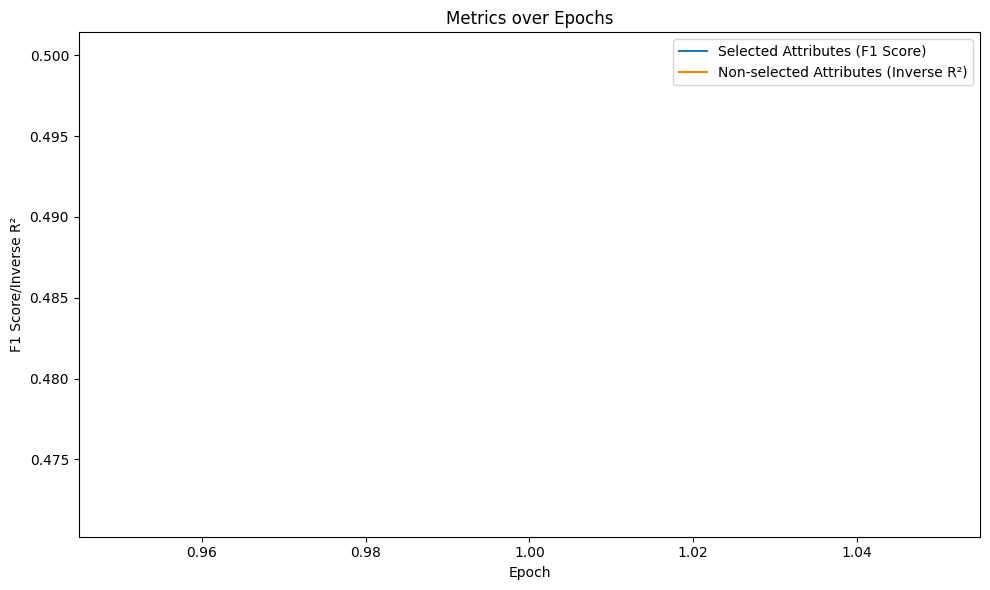

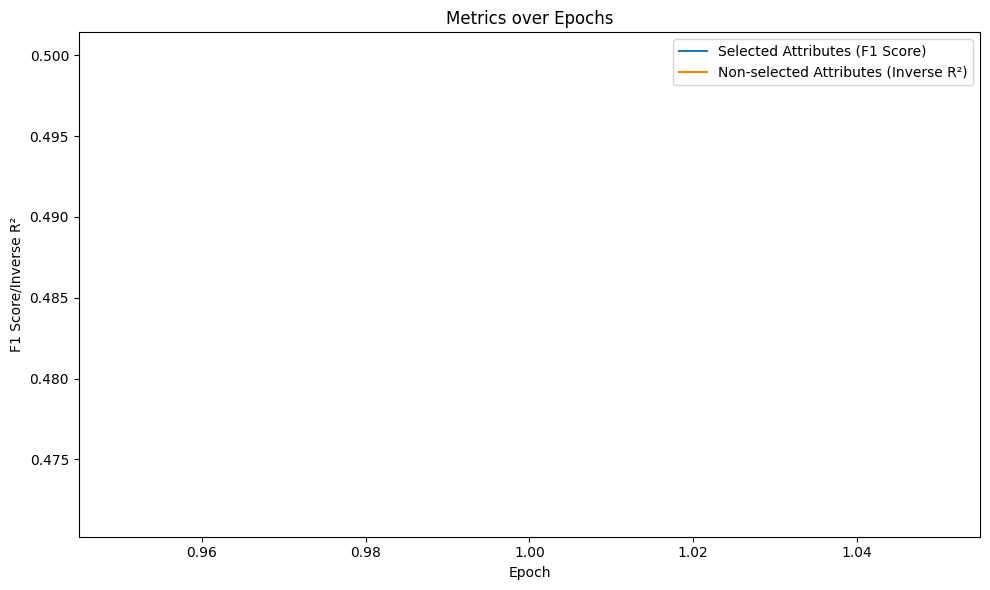

selected_results_dict {'f1_score': [0.4716313825526511], 'r2': []}
non_selected_results_dict {'f1_score': [], 'r2': [-122.84919221022952]}
Training causal model at epoch 1...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Iterations:   0%|          | 0/3115 [00:00<?, ?it/s]

[0/1][100/3115][Time 10.02]
Unified LR across all optimizers: 0.0001993957766378747
--------------------Training Metrics--------------------
CCNet:  Three Tabnet
Inf: 0.0401	Gen: 0.5867	Rec: 0.5865	E: 0.0263	R: 0.0179	P: 1.7267
[0/1][200/3115][Time 9.67]
Unified LR across all optimizers: 0.00019879933411171295
--------------------Training Metrics--------------------
CCNet:  Three Tabnet
Inf: 0.0148	Gen: 0.4425	Rec: 0.4420	E: 0.0128	R: 0.0085	P: 0.9830
[0/1][300/3115][Time 9.86]
Unified LR across all optimizers: 0.00019820467569398644
--------------------Training Metrics--------------------
CCNet:  Three Tabnet
Inf: 0.0104	Gen: 0.4088	Rec: 0.4083	E: 0.0106	R: 0.0086	P: 0.8914
[0/1][400/3115][Time 10.18]
Unified LR across all optimizers: 0.00019761179604798148
--------------------Training Metrics--------------------
CCNet:  Three Tabnet
Inf: 0.0102	Gen: 0.3875	Rec: 0.3876	E: 0.0055	R: 0.0126	P: 0.8587
[0/1][500/3115][Time 10.23]
Unified LR across all optimizers: 0.0001970206898529479
---

In [12]:
train_causal_and_prediction_models(X, y_class, y_amount, task_type_class, task_type_amount, scale_class, scale_amount)

In [ ]:
train_causal_and_prediction_models(X, y_amount, y_class, task_type_amount, task_type_class, scale_amount, scale_class)

# Credit Card Fraud Detection: Handling Imbalanced Dataset with CCNet

## Introduction

This tutorial explores the use of a Cooperative Network (CCNet) to address challenges associated with imbalanced datasets in the domain of credit card fraud detection. By leveraging the power of data generation, we aim to enhance the diversity and volume of training data, thereby improving the robustness and accuracy of models designed to identify fraudulent transactions.

## Tutorial Goals

The objectives of this tutorial are designed to guide you through the process of enhancing data quality and model performance:

### Dataset Recreation with CCNet
- **Understand Data Augmentation**: Learn how encoding techniques can be used to generate synthetic data instances that closely mimic the characteristics of real-world fraudulent and non-fraudulent transactions.
- **Impact on Model Training**: Assess how augmenting the dataset influences the training process and subsequently, the model's ability to generalize from training to real-world scenarios.

### Model Training and Evaluation
- **Dual Model Training**: Train two distinct models to directly compare performance metrics:
  - A model trained on the **original dataset**.
  - A model trained on the **CCNet-augmented dataset**.
- **Performance Metrics**: Use the F1 score, a critical measure for models operating on imbalanced datasets, to evaluate and compare the effectiveness of these models.

### Testing and Validation
- **Independent Model Testing**: Conduct a thorough evaluation of both models using a standalone test set that was not involved in the training phase.
- **Objective Analysis**: Critically analyze the outcomes to validate whether data augmentation through CCNet offers a tangible benefit in detecting credit card fraud.

## Conclusion

By the end of this tutorial, participants will not only grasp the theoretical underpinnings of using synthetic data to combat data imbalance but also gain hands-on experience in applying these concepts through CCNet to potentially enhance model performance in fraud detection tasks.


In [ ]:
# Set a fixed random seed for reproducibility of experiments
from nn.utils.init import set_random_seed
set_random_seed(0)

# Importing configuration setups for ML parameters and data
import torch
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig
from trainer_hub import TrainerHub

# Configuration for the data handling, defining dataset specifics and the task type
data_config = DataConfig(dataset_name='CreditCardFraudDetection', task_type='binary_classification', obs_shape=[num_features], label_size=1, explain_size=num_features - 1)

# Initializing ML parameters without a core model and setting the encoder model to 'tabnet' with specific configurations
ml_params = MLParameters(ccnet_network='tabnet', encoder_network='none')

# Setting training parameters and device configuration
ml_params.training.num_epoch = 10
ml_params.model.ccnet_config.num_layers = 4
ml_params.algorithm.error_function = 'mse'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Create a TrainerHub instance to manage training and data processing
trainer_hub = TrainerHub(ml_params, data_config, device, use_print=True, use_wandb=False)


In [ ]:
X_train, X_test = train_test_split(X, test_size=0.3, shuffle=False)
y_train, y_test = train_test_split(y_class, test_size=0.3, shuffle=False)

# Labeled datasets for supervised learning tasks
trainset = LabeledDataset(X_train, y_train)  # Corrected to include training data
testset = LabeledDataset(X_test, y_test)     # Test set with proper labels

In [ ]:
trainer_hub.train(trainset)

In [ ]:
import torch
from tools.loader import collate_fn

len_trainset = len(trainset)
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=256, collate_fn=collate_fn, shuffle=False)
causal_model = trainer_hub.ccnet
# Initialize the recreated dataset container

# Generate synthetic data through the model to augment the training dataset
data = X_train.to(device)
# Generate a large amount of synthetic data
explain = causal_model.explain(data)

generated_data, generated_label = causal_model.generate(explain)

recreated_training_data = generated_data.squeeze(1).detach().cpu()
recreated_labels = generated_label.detach().cpu().argmax(dim=-1).unsqueeze(-1)


print(f"Recreated Training Data Shape: {recreated_training_data.shape}")
print(f"Recreated Labels Shape: {recreated_labels.shape}")


In [ ]:
import torch

# Assuming recreated_dataset is a PyTorch tensor already available in your context
ccnet_recreated_dataset = LabeledDataset(recreated_training_data.numpy(), recreated_labels.numpy())

# Print the shapes of the datasets for verification
print(f"Labeled Original Trainset Shape: {len(trainset)}, {trainset.x.shape[1]}")
print(f"CCNet Recreated Dataset Shape: {len(ccnet_recreated_dataset)}, {ccnet_recreated_dataset.x.shape[1]}")

print(f"Labeled Original Testset Shape: {len(testset)}, {testset.x.shape[1]}")

# Retrieve number of features and classes from the recreated dataset
num_features = recreated_training_data.shape[1]
num_classes = recreated_labels.shape[1]

print(f"Number of Features: {num_features}")
print(f"Number of Classes: {num_classes}")

In [ ]:
def train_supervised_model(model, dataset, num_epoch=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    # Initialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Ensure reproducibility by resetting the random seed
    # Create DataLoader for batch processing
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    # Training loop
    for epoch in range(num_epoch):  # Train for 2 epochs as an example
        for i, (data, label) in enumerate(trainloader):
            data = data.to(device).clone().detach()
            label = label.to(device).float()
            # Perform forward pass
            output = model(data)
            # Compute loss
            loss = torch.nn.functional.binary_cross_entropy(output, label)
            # Backward pass to compute gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Reset gradients
            optimizer.zero_grad()


In [ ]:
# Initialize and train a model on the recreated dataset
model_trained_on_recreated = PredictionModel(input_size=num_features, output_size=num_classes, task_type='binary_classification').to(device)
train_supervised_model(model_trained_on_recreated, ccnet_recreated_dataset)

# Initialize and train a model on the original dataset
model_trained_on_original = PredictionModel(input_size=num_features, output_size=num_classes, task_type='binary_classification').to(device)
train_supervised_model(model_trained_on_original, trainset)

In [ ]:
from sklearn.metrics import f1_score

def get_f1_score(model, testset, batch_size=256):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    # DataLoader for testing
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    # No gradient computation needed during inference
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            # Process output for binary classification
            predicted = (output.squeeze() > 0.5).long()
            y_true.extend(label.squeeze().long().cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute and return the F1 score
    score = f1_score(y_true, y_pred, average='binary')
    return score

# Calculate F1 scores for both models
f1_score_original = get_f1_score(model_trained_on_original, testset)
f1_score_recreated = get_f1_score(model_trained_on_recreated, testset)

# Output the results
print("F1 score of the supervised learning model trained on the original data: ", f1_score_original)
print("F1 score of the supervised learning model trained on the recreated data: ", f1_score_recreated)
